In [23]:
import pandas as pd
import numpy as np
from orbit.models.ets import ETSMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [25]:
raw_df = load_iclaims()
raw_df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [26]:
df=raw_df.copy()

In [27]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [29]:
ets = ETSMAP(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=2020,
)

In [30]:
ets.fit(train_df)

In [32]:
predicted_df = ets.predict(df=df, decompose=True)
predicted_df

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95
0,2010-01-03,13.283234,13.386595,13.486332,12.947653,13.051014,13.150751,0.335581,0.335581,0.335581
1,2010-01-10,13.516940,13.617983,13.718002,12.951297,13.052341,13.152360,0.565642,0.565642,0.565642
2,2010-01-17,13.283215,13.382794,13.485597,12.956156,13.055735,13.158538,0.327059,0.327059,0.327059
3,2010-01-24,13.044197,13.146663,13.248744,12.951329,13.053795,13.155876,0.092868,0.092868,0.092868
4,2010-01-31,13.071171,13.172100,13.271859,12.958115,13.059043,13.158803,0.113056,0.113056,0.113056
...,...,...,...,...,...,...,...,...,...,...
438,2018-05-27,12.140625,12.329127,12.513435,12.238903,12.427405,12.611714,-0.098278,-0.098278,-0.098278
439,2018-06-03,12.081351,12.269740,12.459036,12.239017,12.427405,12.616701,-0.157665,-0.157665,-0.157665
440,2018-06-10,12.179893,12.368060,12.555767,12.239238,12.427405,12.615112,-0.059345,-0.059345,-0.059345
441,2018-06-17,12.150347,12.338719,12.526869,12.239033,12.427405,12.615556,-0.088687,-0.088687,-0.088687


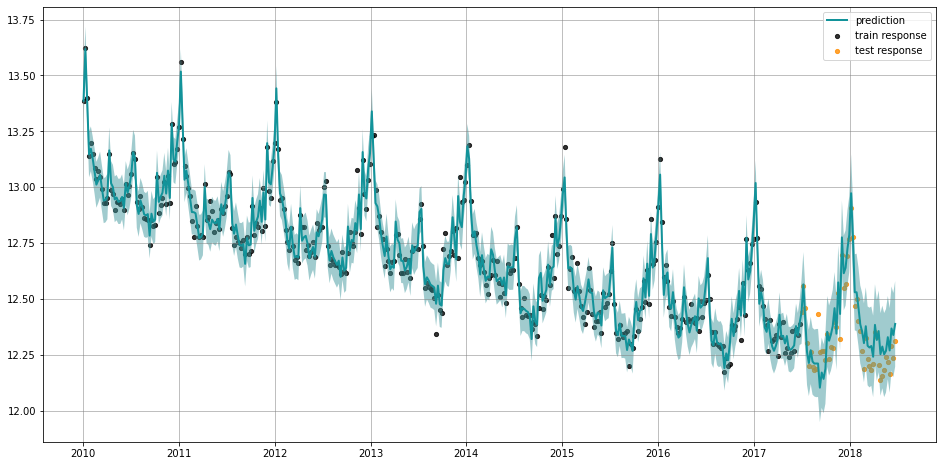

In [33]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from copy import deepcopy

from orbit.constants.constants import PredictedComponents
from orbit.utils.general import is_empty_dataframe
from orbit.constants.palette import QualitativePalette

def plot_predicted_components(predicted_df, date_col, prediction_percentiles=None, plot_components=None,
                              title="", figsize=None, path=None):
    """ Plot predicted componenets with the data frame of decomposed prediction where components
    has been pre-defined as `trend`, `seasonality` and `regression`.
    Parameters
    ----------
    predicted_df: pd.DataFrame
        predicted data response data frame. two columns required: actual_col and pred_col. If
        user provide pred_percentiles_col, it needs to include them as well.
    date_col: str
        the date column name
    prediction_percentiles: list
        a list should consist exact two elements which will be used to plot as lower and upper bound of
        confidence interval
    plot_components: list
        a list of strings to show the label of components to be plotted; by default, it uses values in
        `orbit.constants.constants.PredictedComponents`.
    title: str
        title of the plot
    figsize: tuple
        figsize pass through to `matplotlib.pyplot.figure()`
    path: str
        path to save the figure
   Returns
    -------
        None
    """

    _predicted_df=predicted_df.copy()
    _predicted_df[date_col] = pd.to_datetime(_predicted_df[date_col])
    if plot_components is None:
        plot_components = [PredictedComponents.TREND.value,
                           PredictedComponents.SEASONALITY.value,
                           PredictedComponents.REGRESSION.value]

    plot_components = [p for p in plot_components if p in _predicted_df.columns.tolist()]
    n_panels = len(plot_components)
    if not figsize:
        figsize=(16, 8)

    if prediction_percentiles is None:
        _pred_percentiles = [5, 95]
    else:
        _pred_percentiles = prediction_percentiles

    if len(_pred_percentiles) != 2:
        raise ValueError("prediction_percentiles has to be None or a list with length=2.")

    fig, axes = plt.subplots(n_panels, 1, facecolor='w', figsize=figsize)
    for ax, comp in zip(axes, plot_components):
        y = predicted_df[comp].values
        ax.plot(_predicted_df[date_col], y, marker=None, color='#12939A')
        confid_cols = ["{}_{}".format(comp, _pred_percentiles[0]), "{}_{}".format(comp, _pred_percentiles[1])]
        if set(confid_cols).issubset(predicted_df.columns):
            ax.fill_between(_predicted_df[date_col].values,
                            _predicted_df[confid_cols[0]],
                            _predicted_df[confid_cols[1]],
                            facecolor='#42999E', alpha=0.5)
        ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.5)
        ax.set_title(comp, fontsize=16)
    plt.suptitle(title, fontsize=16)
    fig.tight_layout()

    if path:
        plt.savefig(path)

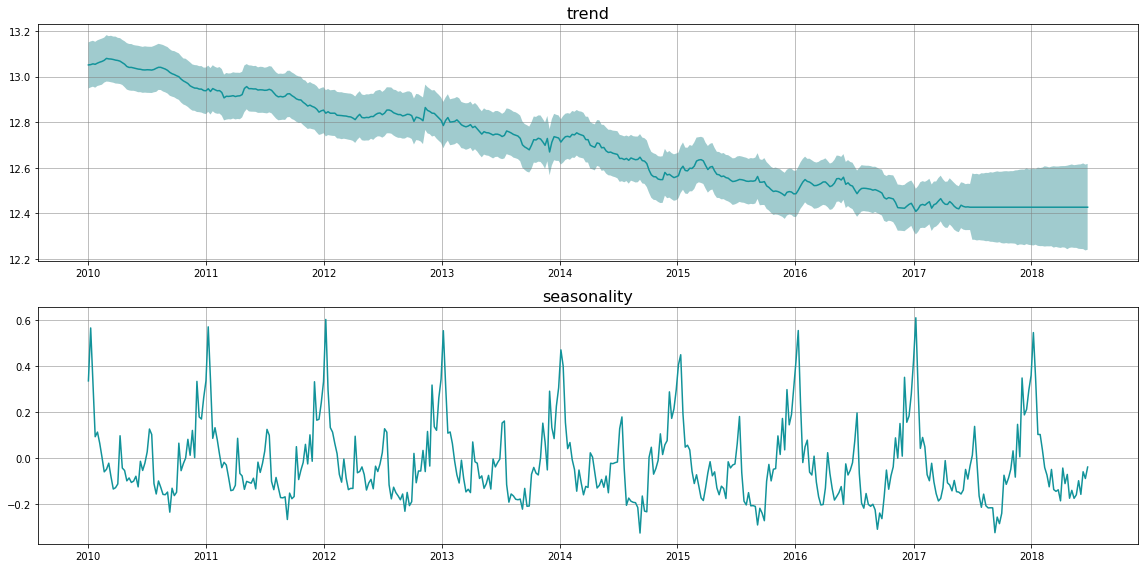

In [14]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')